# Capacitación de Clases para Clasificación con CLIP

## 1. Introducción y Configuración Inicial
Este notebook tiene como objetivo preparar el modelo CLIP (Contrastive Language–Image Pre-training) para la clasificación de imágenes basada en la similitud de texto e imagen. Se realizarán dos tareas principales:

- Definir una Región de Interés (ROI) en una imagen patrón, la cual será usada para enfocar la atención del modelo en áreas específicas de las imágenes durante la inferencia.

- Calcular y guardar los embeddings de las imágenes patrón de un dataset específico.

## Importación de Biliotecas

In [33]:
import os
import json
import torch
import numpy as np
from PIL import Image
from sentence_transformers import SentenceTransformer, util
import ipywidgets as widgets
from IPython.display import display, clear_output

## Configuración Inicial

In [34]:
# Especificar la carpeta donde se encuentran los datasets
datasets_path = "./datasets"

# Especificar el modelo CLIP a utilizar
clip_model_name = "clip-ViT-B-32"

# Determinar si CUDA está disponible y configurar el dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo seleccionado: {device}")

# Cargar el modelo CLIP
model = SentenceTransformer(clip_model_name, device=device, cache_folder='./cache_models')

# Variable para almacenar la información de la ROI
roi_info = None

# Solicitar al usuario que ingrese el nombre del dataset con el que desea trabajar
dataset_name = input("Por favor, ingresa el nombre del dataset con el que deseas trabajar: ")
dataset_path = os.path.join(datasets_path, dataset_name)

# Verificar que el dataset existe
if not os.path.exists(dataset_path):
    raise ValueError("El dataset especificado no existe. Por favor, verifica el nombre e inténtalo de nuevo.")

print(f"Trabajando con el dataset: {dataset_name}")
print("Configuración inicial completada. Modelo CLIP cargado y listo para usarse.")

Dispositivo seleccionado: cuda


Por favor, ingresa el nombre del dataset con el que deseas trabajar:  jeansel


Trabajando con el dataset: jeansel
Configuración inicial completada. Modelo CLIP cargado y listo para usarse.


## 2. Selección del Dataset y Visualización de Imagen Patrón

En esta sección, nos centraremos en la selección de un dataset específico, la visualización de una imagen patrón y la definición de una región de interés (ROI) en esa imagen. La información sobre la ROI se guardará en un archivo "config.json" para su uso posterior.

## Selección del Dataset


Clase seleccionada para la demostración: left gap


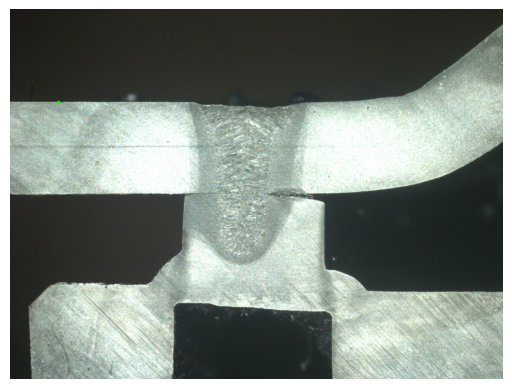

In [35]:
import matplotlib.pyplot as plt
import random

# Definir la ruta a la carpeta de clases del dataset
classes_folder_path = os.path.join(dataset_path, 'Classes')

# Verificar que la carpeta de clases existe
if not os.path.exists(classes_folder_path):
    raise ValueError("No se encontró la carpeta 'Classes' dentro del dataset. Por favor, verifica la estructura del dataset.")

# Obtener la lista de carpetas de clases
class_folders = [f for f in os.listdir(classes_folder_path) if os.path.isdir(os.path.join(classes_folder_path, f))]
if not class_folders:
    raise ValueError("No se encontraron carpetas de clases dentro del dataset. Por favor, verifica la estructura del dataset.")

# Seleccionar una carpeta de clase al azar para simplificar la demostración
random_class_folder = random.choice(class_folders)
print(f"Clase seleccionada para la demostración: {random_class_folder}")

# Obtener la lista de imágenes en la carpeta de clase seleccionada
class_folder_path = os.path.join(classes_folder_path, random_class_folder)
image_files = [f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))]
if not image_files:
    raise ValueError("No se encontraron imágenes en la carpeta de clase seleccionada. Por favor, verifica la carpeta.")

# Seleccionar una imagen al azar para la demostración
patron_image_file = random.choice(image_files)
patron_image_path = os.path.join(class_folder_path, patron_image_file)

# Mostrar la imagen seleccionada
img = Image.open(patron_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


## Visualización de Imagen Patrón y Definición de la ROI
Para la definición de la ROI, puedes usar herramientas interactivas como OpenCV o widgets en Jupyter para seleccionar la región directamente en la imagen.

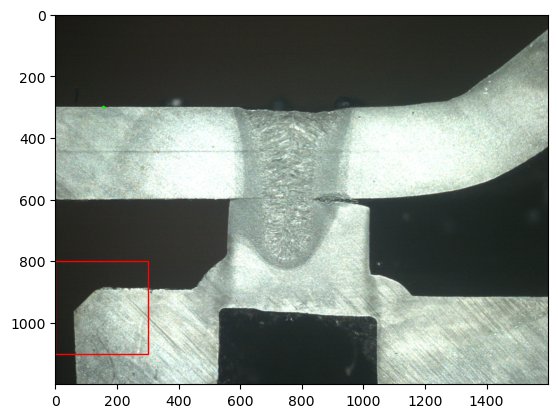

In [37]:
# Definir las coordenadas y dimensiones del BBox
x = 0      # Coordenada x del vértice superior izquierdo
y = 800      # Coordenada y del vértice superior izquierdo
height = 300 # Altura del BBox
width = 300   # Ancho del BBox

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Cargar la imagen ejemplo
img = plt.imread(patron_image_path)

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Mostrar la imagen
ax.imshow(img)

# Crear un rectángulo que represente el BBox
rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

# Añadir el rectángulo a los ejes
ax.add_patch(rect)

# Mostrar la imagen con el BBox
plt.show()


## Guardado de la Configuración de la ROI
Finalmente, vamos a guardar la información de la ROI y otros detalles relevantes en un archivo "config.json".

In [38]:
roi = {
    "x": x,
    "y": y,
    "height": height,
    "width": width
}

config = {
    'dataset_name': dataset_name,
    'roi': roi
}

config_file_path = os.path.join(dataset_path, 'config.json')
with open(config_file_path, 'w') as f:
    json.dump(config, f)

print(f"Configuración guardada en: {config_file_path}")


Configuración guardada en: ./datasets/jeansel/config.json


## 3. Cálculo de Embeddings para Imágenes Patrón

## Carga de la Configuración y Acceso a las Imágenes Patrón

Primero, necesitamos cargar la configuración que guardamos anteriormente para obtener la región de interés (ROI) y la ruta al dataset.

In [39]:
# Cargar la configuración
config_file_path = os.path.join('datasets', dataset_name, 'config.json')
with open(config_file_path, 'r') as f:
    config = json.load(f)

roi = config['roi']
dataset_path = os.path.join('datasets', config['dataset_name'])
classes_path = os.path.join(dataset_path, 'Classes')

# Listar las carpetas de clases, excluyendo archivos ocultos y asegurándose de que son directorios
class_folders = [f for f in os.listdir(classes_path) if not f.startswith('.') and os.path.isdir(os.path.join(classes_path, f))]
class_folders


['left gap', 'right gap']

## Cálculo de Embeddings

In [40]:
embeddings_path = os.path.join(dataset_path, 'Classes')
os.makedirs(embeddings_path, exist_ok=True)

for class_folder in class_folders:
    class_path = os.path.join(classes_path, class_folder)
    embeddings_folder = os.path.join(embeddings_path, class_folder)
    os.makedirs(embeddings_folder, exist_ok=True)
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.jpg', '.png', '.bmp', '.tif', '.tiff')):
            
            img_path = os.path.join(class_path, img_file)
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)

            # Aplicar la ROI si está definida
            if roi:
                img = img.crop((roi['x'], roi['y'], roi['x'] + roi['width'], roi['y'] + roi['height']))

            # Calcular el embedding
            img_embedding = model.encode(img).astype(float)

            # Guardar el embedding
            embedding_file_path = os.path.join(embeddings_folder, img_file.replace('.png', '.npy').replace('.jpg', '.npy'))
            np.save(embedding_file_path, img_embedding)
        
print("Embeddings calculados y guardados con éxito.")


Embeddings calculados y guardados con éxito.
